# Comparison with simple kernel

In this notebook, we compare the performance of `gallifrey` models with that of more classical GP approaches. We will fit transit parameters using the learned covariance structure of `gallifrey` through SMC, and a simple RBF kernel where we only perform sampling over the continous parameters and not the kernel structure.

## Notebook setup

Same as in the other tutorials, we first setup the notebook

In [15]:
import multiprocessing
import os

os.environ["XLA_FLAGS"] = (
    f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
)

In [1]:
# import libraries
import pathlib
from collections import OrderedDict

import blackjax
import jax
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from blackjax.util import run_inference_algorithm
from jax import numpy as jnp
from jax import random as jr
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit

from gallifrey import GPConfig, GPModel, LinearSchedule
from gallifrey.kernels import RBFAtom, SumOperator, ProductOperator

gallifrey: Setting flag `JAX_ENABLE_X64` to `True`
gallifrey: Setting flag `OMP_NUM_THREADS` to `1`


In [2]:
# notebook settings

# making the plots pretty
sns.set_theme(
    context="poster",
    style="ticks",
    palette="rocket",
    font_scale=1,
    rc={
        "figure.figsize": (16, 7),
        "axes.grid": False,
        "font.family": "serif",
        "text.usetex": True,
        "lines.linewidth": 5,
        # "axes.grid": True,
    },
)

# setting saving defaults
save_figures = True
load_models = True  # load pre-trained models
save_models = False  # save trained models, only works if load_models is False

# set saving paths
path = pathlib.Path.cwd().parent
figure_directory = path / "figures/mcmc_comparison/"
if not figure_directory.exists():
    figure_directory.mkdir(parents=True)

# set a random key for for this notebook
rng_key = jr.PRNGKey(77)

## Create toy data

In this example, we create some toy data for the model comparison. We will try to challenge the Gaussian Processes a bit: We will vary the 'stellar' background on two time scales, and add noise generated by an autoregressive process rather than pure white noise. The AR(1) process is a commonly used model for correlated noise with exponentially decaying ('short memory') autocorrelation. We also create the transit model. For this example, we will treat the period, transit duration, transit timing and impact parameter as known quantities. We will fit the planet-to-star radius ratio and limb darkening coefficients.

In [3]:
# create transit model
def transit_model(t, params, period=10.0, duration=0.2, t0=0.0, impact_param=0.0):
    orbit = TransitOrbit(
        period=jnp.array(period),
        duration=jnp.array(duration),
        time_transit=jnp.array(t0),
        impact_param=jnp.array(impact_param),
        radius_ratio=params["r"],
    )
    return limb_dark_light_curve(orbit, jnp.array([params["u1"], params["u2"]]))(t)

In [4]:
key, noise_key = jr.split(rng_key, 2)

# generate the deterministic data
full_time = jnp.linspace(-0.8, 0.8, 1000)
background = 0.003 * (
    5 * full_time**2 + jnp.sin(20 * full_time) + 0.3 * jnp.cos(50 * full_time)
)

# generate white noise
white_noise_stddev = 0.001
white_noise = white_noise_stddev * jr.normal(noise_key, (len(full_time),))
# generate AR(1) noise
noise_auto_corr = 0.1
ar_noise = jnp.zeros(len(full_time))
ar_noise = ar_noise.at[0].set(white_noise[0])
for i in range(1, len(full_time)):
    ar_noise = ar_noise.at[i].set(noise_auto_corr * ar_noise[i - 1] + white_noise[i])

# generate the transit signal
transit_params = {"r": 0.1, "u1": 0.1, "u2": 0.3}
transit = transit_model(full_time, transit_params)

# generate the light curve
full_ight_curve = transit + background + ar_noise

# select a subset of the data as mock observations
num_train = 150
obs_idx = jnp.sort(jr.choice(rng_key, len(full_time), (num_train,), replace=False))
time = full_time[obs_idx]
light_curve = full_ight_curve[obs_idx]

# get transit mask
transit_mask = (time > -0.12) & (time < 0.12)

xtrain = time[~transit_mask]
ytrain = light_curve[~transit_mask]

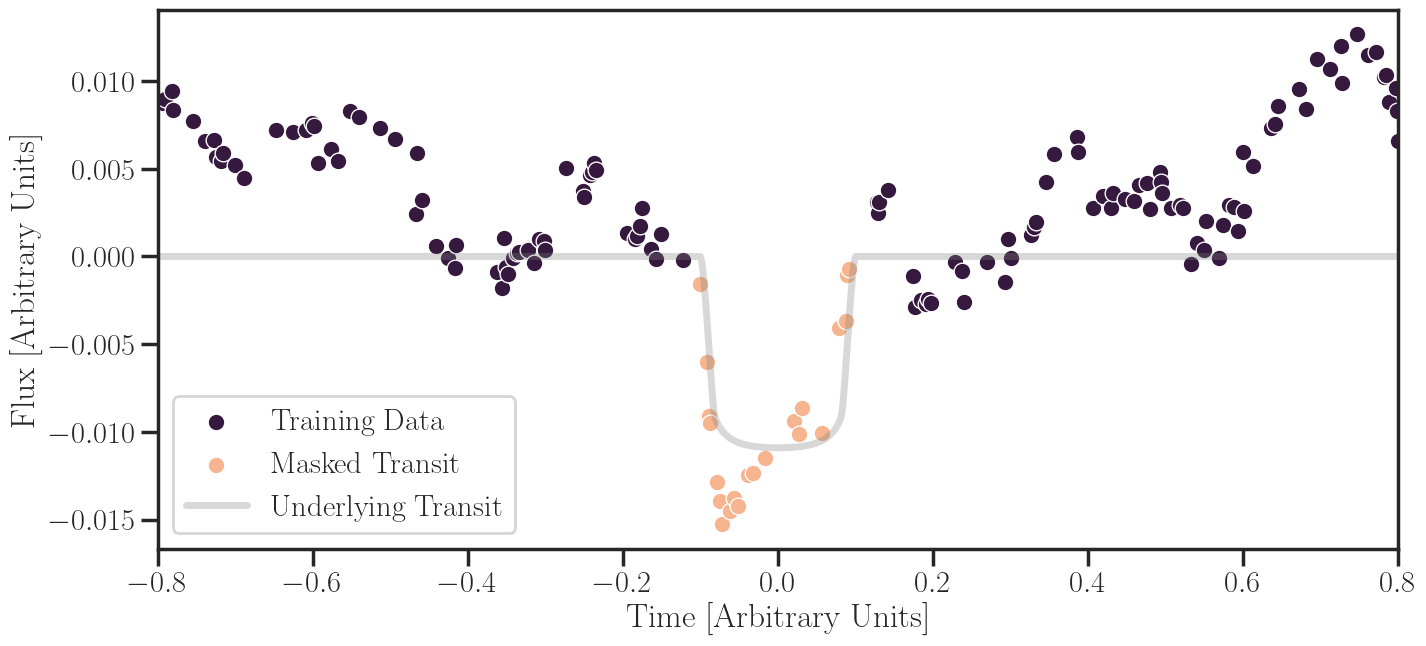

In [5]:
# visualize the transit
data_plot = sns.scatterplot(
    x=time[~transit_mask],
    y=light_curve[~transit_mask],
    label="Training Data",
    color="C0",
)
sns.scatterplot(
    x=time[transit_mask],
    y=light_curve[transit_mask],
    label="Masked Transit",
    color="C5",
    ax=data_plot,
)

sns.lineplot(
    x=full_time,
    y=transit,
    color="grey",
    alpha=0.3,
    ax=data_plot,
    label="Underlying Transit",
)

data_plot.set_xlabel("Time [Arbitrary Units]")
data_plot.set_ylabel("Flux [Arbitrary Units]")
data_plot.set_xlim(-0.8, 0.8)

if save_figures:
    plt.savefig(figure_directory / "data_plot.pdf", bbox_inches="tight")

## Fitting the `gallifrey` model

For this tutorial, we will use the default `gallifrey` GPConfig, which uses the Linear, RBF, and Periodic kernel as base kernels.

In [6]:
# create GP model instance
key, gallifrey_key = jr.split(rng_key)
learned_model = GPModel(
    gallifrey_key,
    x=xtrain,
    y=ytrain,
    num_particles=8,
    config=GPConfig(),
)

In [7]:
# run the model
if load_models is False:
    key, smc_key = jr.split(key)
    final_smc_state, history = learned_model.fit_smc(
        smc_key,
        annealing_schedule=LinearSchedule().generate(len(xtrain), 30),
        n_mcmc=75,
        n_hmc=10,
        verbosity=0,
    )
    if save_models:
        learned_model.save_state(
            str(path / "model_checkpoints/mcmc_comparison_learned/final_state.pkl"),
            final_smc_state,
        )
        learned_model.save_state(
            str(path / "model_checkpoints/mcmc_comparison_learned/history.pkl"),
            history,
        )
else:
    final_smc_state = learned_model.load_state(
        str(path / "model_checkpoints/mcmc_comparison_learned/final_state.pkl")
    )
    history = learned_model.load_state(
        str(path / "model_checkpoints/mcmc_comparison_learned/history.pkl")
    )

# update the model with the new state
learned_model = learned_model.update_state(final_smc_state)

## Fitting the RBF model

As a comparison, we fit a model with `max_depth`=0 and only containing the RBF atom. We include the two operators, but since the max_depth is 0 and their probabilities are set to 0, they are just dummies. We effectively skip the MCMC moves over the kernel structure and perform only HMC over the kernel parameters.

In [8]:
# create GP model instance
key, rbf_key = jr.split(rng_key)

config = GPConfig(
    max_depth=0,
    atoms=[RBFAtom()],
    operators=[SumOperator(), ProductOperator()],
    node_probabilities=jnp.array([1.0, 0.0, 0.0]),
)

rbf_model = GPModel(
    rbf_key,
    x=xtrain,
    y=ytrain,
    num_particles=8,
    config=config,
)

In [9]:
# run the model
if load_models is False:
    key, smc_key = jr.split(key)
    final_smc_state, history = rbf_model.fit_smc(
        smc_key,
        annealing_schedule=LinearSchedule().generate(len(xtrain), 30),
        n_mcmc=75,
        n_hmc=10,
        verbosity=0,
    )
    if save_models:
        rbf_model.save_state(
            str(path / "model_checkpoints/mcmc_comparison_rbf/final_state.pkl"),
            final_smc_state,
        )
        rbf_model.save_state(
            str(path / "model_checkpoints/mcmc_comparison_rbf/history.pkl"),
            history,
        )
else:
    final_smc_state = rbf_model.load_state(
        str(path / "model_checkpoints/mcmc_comparison_rbf/final_state.pkl")
    )
    history = rbf_model.load_state(
        str(path / "model_checkpoints/mcmc_comparison_rbf/history.pkl")
    )

# update the model with the new state
rbf_model = rbf_model.update_state(final_smc_state)

## Model comparison

We can know visualise how well boh models fit the data:

In [10]:
# create predictive distributions and mean/stddev
xall_norm = []
predictive_gmms = []
means = []
stddevs = []

for model in [rbf_model, learned_model]:
    xall_norm.append(model.x_transform(full_time))
    predictive_gmms.append(model.get_mixture_distribution(xall_norm[-1]))
    means.append(predictive_gmms[-1].mean())
    stddevs.append(predictive_gmms[-1].stddev())

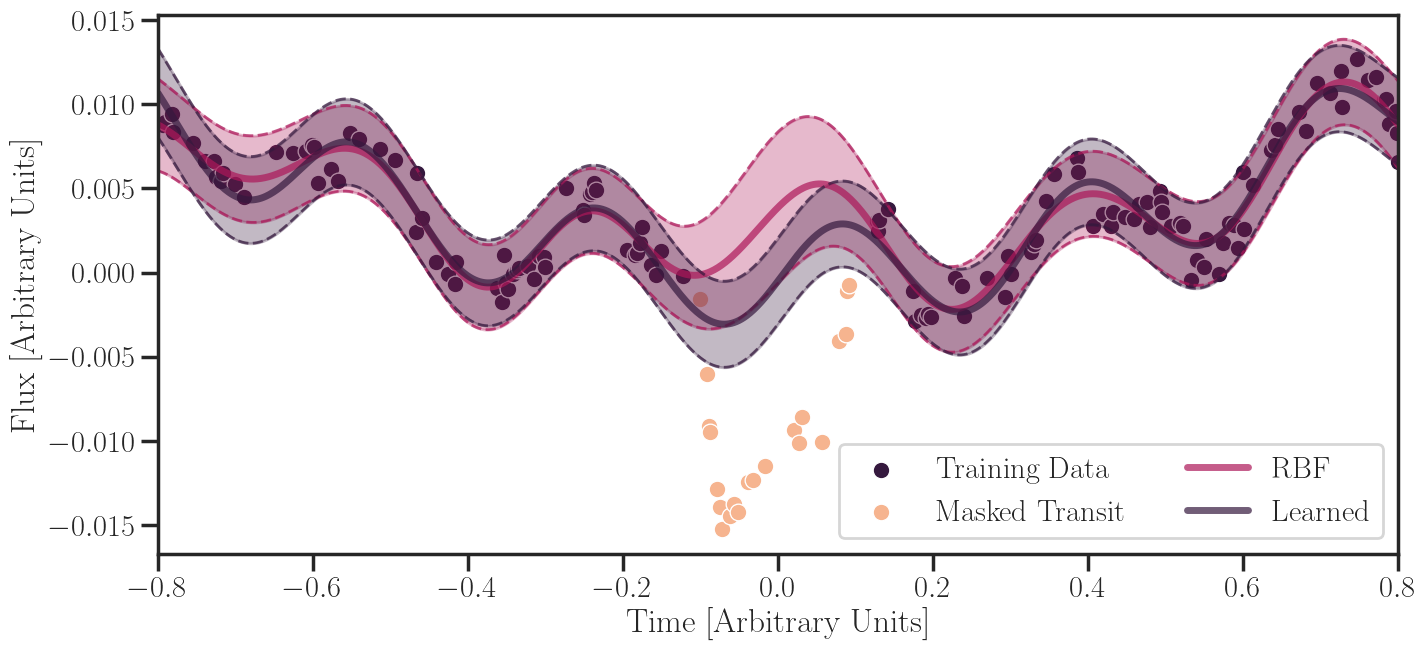

In [11]:
# plot the data
model_comparison_lc_plot = sns.scatterplot(
    x=time[~transit_mask],
    y=light_curve[~transit_mask],
    label="Training Data",
    color="C0",
)
sns.scatterplot(
    x=time[transit_mask],
    y=light_curve[transit_mask],
    label="Masked Transit",
    color="C5",
    ax=model_comparison_lc_plot,
)

# plot the two models
labels = ["RBF", "Learned"]
colors = ["C2", "C0"]
for i in range(len(means)):
    predictive_mean = means[i]
    predictive_stddev = stddevs[i]

    sns.lineplot(
        x=full_time,
        y=learned_model.y_transform.unapply(predictive_mean),
        ax=model_comparison_lc_plot,
        color=colors[i],
        alpha=0.7,
        label=labels[i],
    )

    for offset in [predictive_stddev, -predictive_stddev]:
        sns.lineplot(
            x=full_time,
            y=learned_model.y_transform.unapply(predictive_mean + offset),
            linewidth=2,
            linestyle="--",
            alpha=0.7,
            color=colors[i],
            ax=model_comparison_lc_plot,
        )

    model_comparison_lc_plot.fill_between(
        full_time,
        learned_model.y_transform.unapply(predictive_mean + predictive_stddev),
        learned_model.y_transform.unapply(predictive_mean - predictive_stddev),
        color=colors[i],
        alpha=0.3,
    )
model_comparison_lc_plot.set_xlabel("Time [Arbitrary Units]")
model_comparison_lc_plot.set_ylabel("Flux [Arbitrary Units]")
model_comparison_lc_plot.set_xlim(-0.8, 0.8)
model_comparison_lc_plot.legend(ncol=2)

if save_figures:
    plt.savefig(figure_directory / "model_comparison_lc_plot.pdf", bbox_inches="tight")

We can see that both models fit the data pretty well. In the regions where training data is available, they are pretty much indistinguishable. But in the the masked region where the transit occurs, we can see clear deviations. The model that uses the RBF kernels predicts signficantly larger values compared to the kernel with a learned covariance structure.

## Sampling the transit parameter distribution

We now sample the posterior probability distribution of the transit parameter. We do this in the same way as in the **Transit fitting** tutorial. We use the probability distribution obtained via the SMC sampling as the distribution for the underlying time series without a transit, and use it as the sampling objective. We again assume flat priors over all transit parameters for simplicity. However this time we explicitly constrain the planet-to-stellar radius ratio and the two limb darkening coefficients to lie between 0 and 1. We'll use the quick-and-dirty approach of simply setting the probability to zero, if any of the parameters is outside of this bound.

In [12]:
def objective(params, predictive_gmm, gpmodel):
    transit_light_curve = transit_model(time, params)
    residuals = light_curve - transit_light_curve

    log_prob = predictive_gmm.log_prob(gpmodel.y_transform(residuals))

    # enforce (flat) priors
    log_prob = jnp.where(
        (params["r"] < 0.0)
        | (params["r"] > 1.0)
        | (params["u1"] < 0.0)
        | (params["u1"] > 1.0)
        | (params["u2"] < 0.0)
        | (params["u2"] > 1.0),
        -jnp.inf,
        log_prob,
    )
    return log_prob


initial_guess = OrderedDict(
    {
        "r": jnp.array(0.05),
        "u1": jnp.array(0.5),
        "u2": jnp.array(0.5),
    }
)

We sample the posterior using `blackjax`'s NUTS sampler for both of our models:

In [13]:
mcmc_chains = []

for model in [rbf_model, learned_model]:
    predictive_gmm = model.get_mixture_distribution(model.x_transform(time))
    model_objective = jax.jit(lambda params: objective(params, predictive_gmm, model))

    # parameter adaption and burn-in
    warmup = blackjax.window_adaptation(
        blackjax.nuts,
        model_objective,
        progress_bar=True,
    )
    key, warmup_key, sample_key = jax.random.split(key, 3)
    (burned_in_state, nuts_parameters), _ = warmup.run(
        warmup_key,
        initial_guess,
        num_steps=1000,
    )

    # sampling
    nuts_sampler = blackjax.nuts(model_objective, **nuts_parameters)

    final_state, (history, info) = run_inference_algorithm(
        rng_key=sample_key,
        inference_algorithm=nuts_sampler,
        num_steps=10000,
        initial_state=burned_in_state,
        progress_bar=True,
    )

    # save mcmc chains
    mcmc_df = pd.DataFrame(
        jnp.stack(list(history.position.values())).T,
        columns=list(initial_guess.keys()),
    ).rename(
        columns={
            "r": "Radius Ratio",
            "u1": "$u_1$",
            "u2": "$u_2$",
        }
    )
    mcmc_chains.append(mcmc_df)

mcmc_chains[0]["Kernel"] = "RBF"
mcmc_chains[1]["Kernel"] = "Learned"

mcmc_df = pd.concat(mcmc_chains).reset_index(drop=True)

Running window adaptation


Running window adaptation


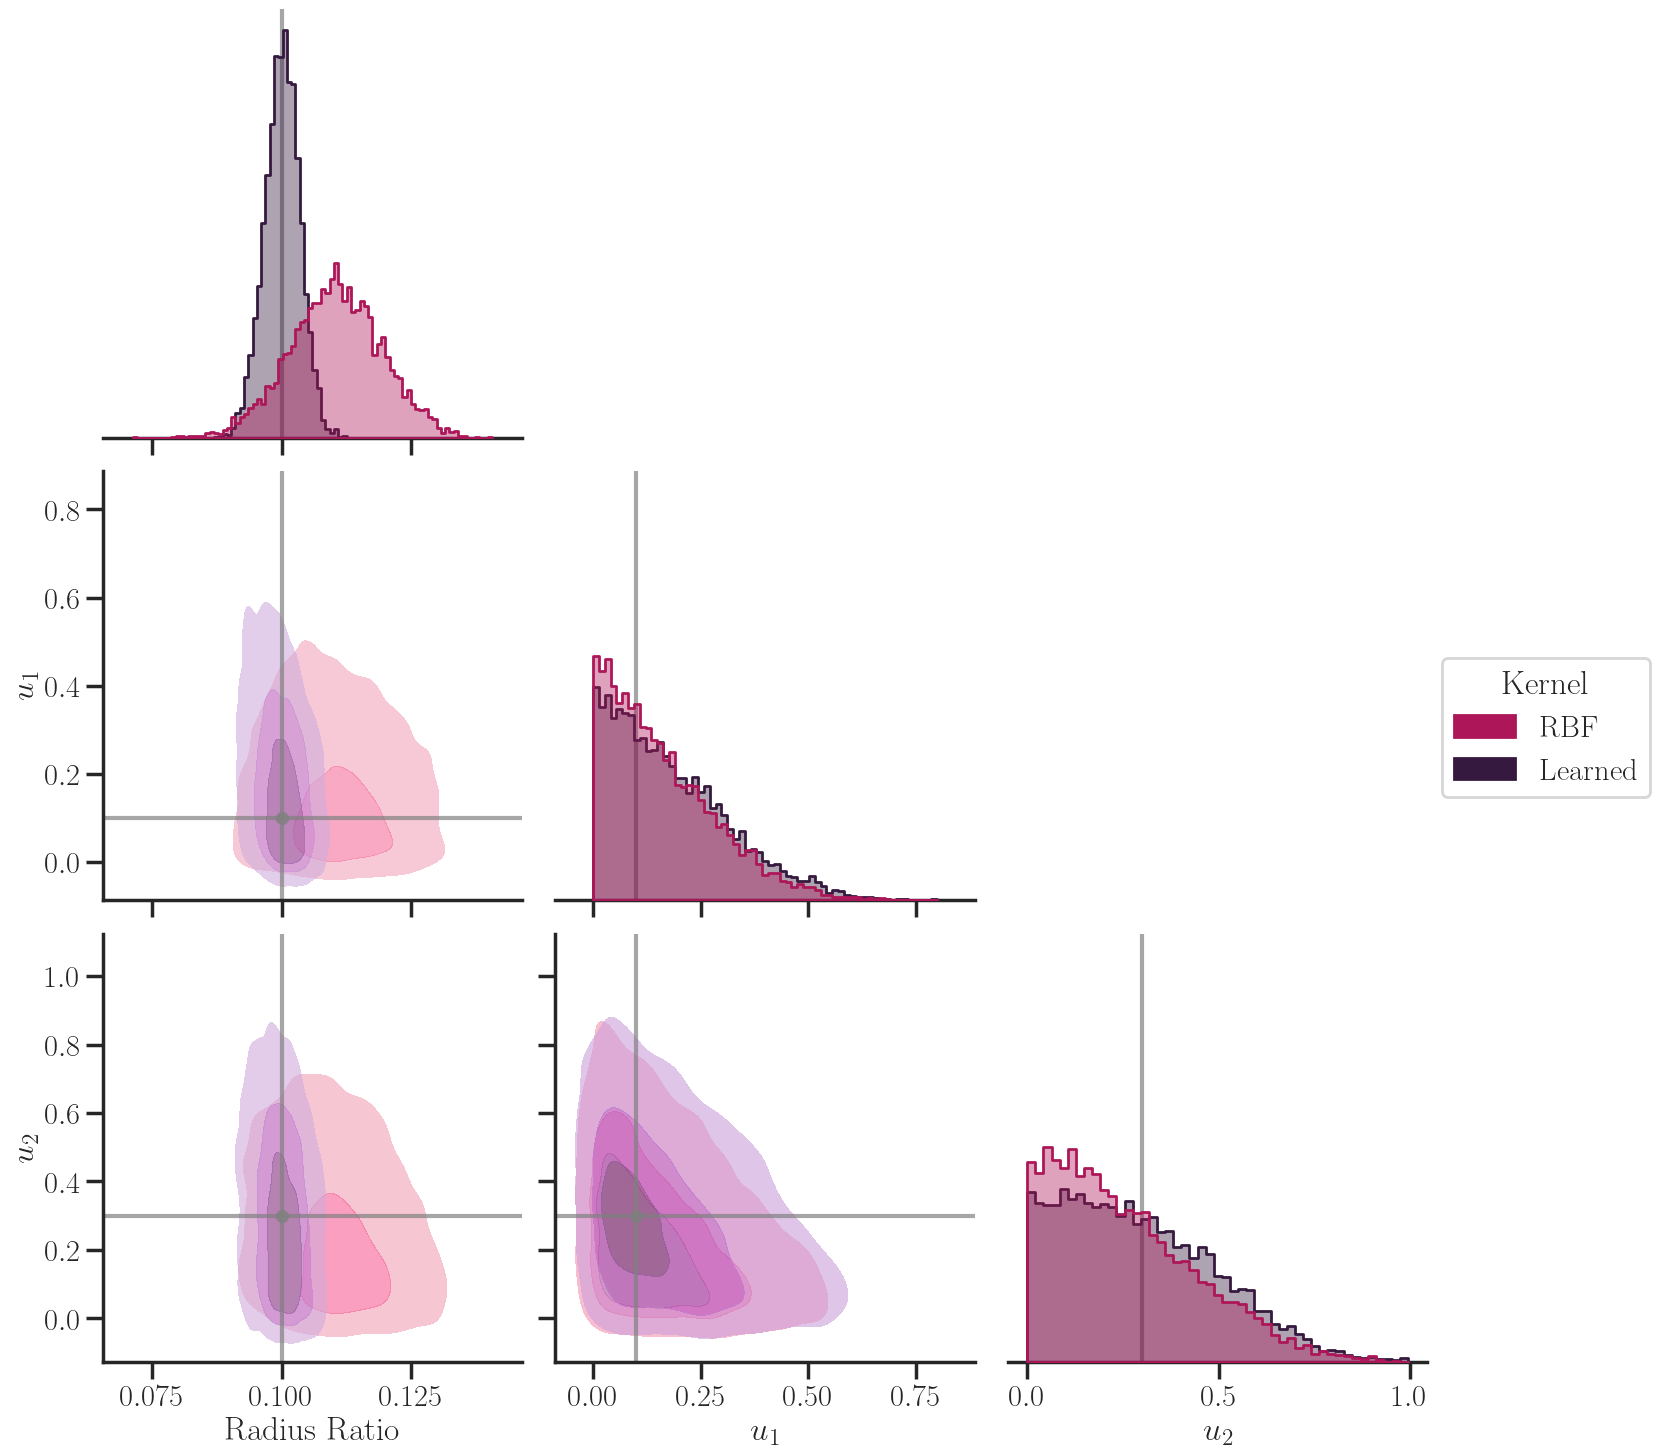

In [14]:
corner_plot = sns.pairplot(
    mcmc_df,
    corner=True,
    hue="Kernel",
    hue_order=["RBF", "Learned"],
    diag_kind="hist",
    palette={"RBF": "C2", "Learned": "C0"},
    kind="kde",
    diag_kws={"element": "step", "alpha": 0.4},
    plot_kws={"fill": True, "alpha": 0.6, "levels": 4},
    height=5,
)

# add ground truth
ground_truth = [0.1, 0.1, 0.3]
for i in range(3):
    for j in range(3):
        if corner_plot.axes[i, j]:
            corner_plot.axes[i, j].axvline(
                ground_truth[j],
                color="grey",
                alpha=0.7,
                linewidth=3,
            )
            if i != j:
                corner_plot.axes[i, j].axhline(
                    ground_truth[i], color="grey", alpha=0.7, linewidth=3
                )
                corner_plot.axes[i, j].scatter(
                    ground_truth[j],
                    ground_truth[i],
                    color="grey",
                    alpha=0.7,
                    s=60,
                )

sns.move_legend(
    corner_plot,
    "center right",
    frameon=True,
)

if save_figures:
    plt.savefig(figure_directory / "comparison_corner_plot.pdf", bbox_inches="tight")

We can see that the posterior distribution for the planet-to-star radius ratio is much more localised and closer to the true value compared to the simple RBF kernel.